In [1]:
from tensorflow import keras

from tensorflow.keras import models, layers  # type: ignore

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error

from tqdm import tqdm
import matplotlib.pyplot as plt 
import numpy as np 

In [14]:
# h0 = 67,45
# omega_m = 0.315


In [2]:
# Preparing the dataset and creating the features and target arrays

n_sims = 10000

x = []
y = []

for i in tqdm(range(n_sims), desc='Carregando dados', ascii=True):
    data = np.load(f'../input47/data_{i+1}.npy')
    x.append(data[:, :2])
    y.append(data[0, 2])  # equivalente a data[:, 2:][0][0]

x = np.array(x)
y = np.array(y)

norm = y.max()
# Normalização
# y /= y.max()


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25)

Carregando dados: 100%|##########| 10000/10000 [00:01<00:00, 6159.51it/s]


In [3]:
# early_stopping = keras.callbacks.EarlyStopping(
#     min_delta=0.001, # minimium amount of change to count as an improvement
#     patience=5, # how many epochs to wait before stopping
#     restore_best_weights=True,
# )

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   
    patience=5,          
    verbose=1,          
    factor=0.5,          
    min_lr=0.00001,
    min_delta=0.001       
)

# learning_rate_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.01,  # Initial learning rate for training
#     decay_steps=5,            # Number of steps before decaying the learning rate
#     decay_rate=0.5,              # Rate at which the learning rate decreases
# )

# lr_callback = keras.callbacks.LearningRateScheduler(learning_rate_schedule)


In [4]:
# defining the model


model = models.Sequential()

# model.add()

model.add(layers.Bidirectional(layers.GRU(16,input_shape=(47,2)) ) )


model.add(layers.Flatten())

model.add(layers.Dense(16))
# model.add(layers.Dropout(.3))

model.add(layers.Dense(1))

model.compile(loss=keras.losses.MeanSquaredError(), optimizer='nadam', metrics=keras.metrics.MeanAbsoluteError())


history = model.fit(x_train, y_train, validation_split=.1, epochs=20, batch_size=8, verbose=1, callbacks=[reduce_lr])

Epoch 1/20
844/844 [==============================] - 16s 15ms/step - loss: 712.4293 - mean_absolute_error: 16.0878 - val_loss: 18.2220 - val_mean_absolute_error: 3.6751 - lr: 0.0010
Epoch 2/20
844/844 [==============================] - 14s 16ms/step - loss: 18.5935 - mean_absolute_error: 3.7312 - val_loss: 16.9875 - val_mean_absolute_error: 3.5497 - lr: 0.0010
Epoch 3/20
844/844 [==============================] - 26s 31ms/step - loss: 12.4793 - mean_absolute_error: 2.9300 - val_loss: 1.6367 - val_mean_absolute_error: 1.0477 - lr: 0.0010
Epoch 4/20
844/844 [==============================] - 24s 29ms/step - loss: 1.5926 - mean_absolute_error: 1.0265 - val_loss: 1.9708 - val_mean_absolute_error: 1.1603 - lr: 0.0010
Epoch 5/20
844/844 [==============================] - 19s 23ms/step - loss: 1.0994 - mean_absolute_error: 0.8627 - val_loss: 0.6770 - val_mean_absolute_error: 0.6921 - lr: 0.0010
Epoch 6/20
844/844 [==============================] - 17s 20ms/step - loss: 0.9169 - mean_absolute

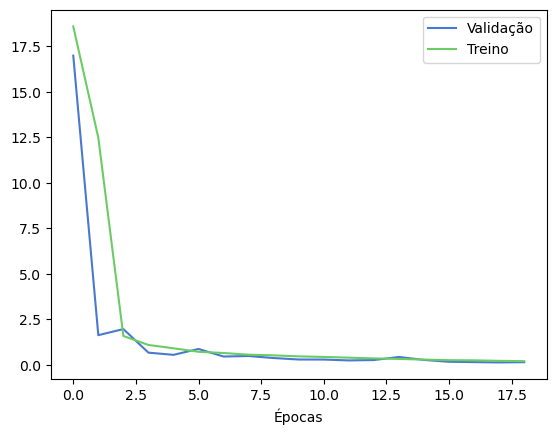

In [9]:
plt.plot(history.history['val_loss'][1:], label='Validação')
plt.plot(history.history['loss'][1:], label='Treino')


plt.xlabel('Épocas')
plt.legend()


# plt.savefig("../imagens/loss_h0_rnn_bi")

plt.show()

Dummy variables just for visualization purposes

In [10]:
y_pred = model.predict(x_test)


r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

# mse

79/79 [==============================] - 0s 5ms/step


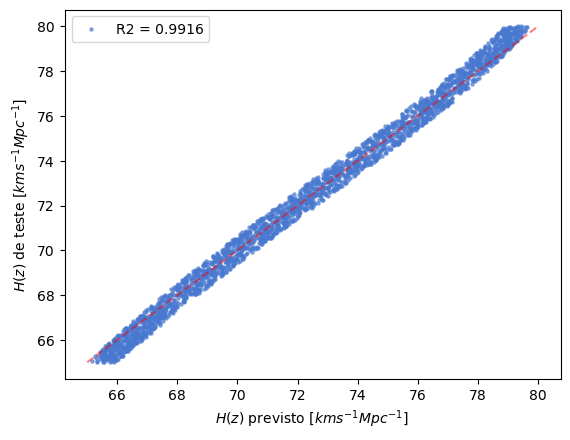

In [11]:
plt.style.use('seaborn-v0_8-muted')

# linha = np.linspace(.3, .35, 2500)
linha = np.linspace(65, 80)

plt.scatter(y_pred, y_test, s=5, alpha=.6, label=f'R2 = {r2:.4f}')
plt.plot(linha, linha, alpha=.5, c='red', ls='--')

plt.legend()


plt.xlabel(r'$H (z)$ previsto [$km s^{-1} Mpc^{-1}$] ')
plt.ylabel(r'$H (z)$ de teste [$km s^{-1} Mpc^{-1}$] ')


# plt.savefig("../imagens/metrics_h0_rnn_bi")
plt.show()

In [12]:
# forecasting "real" H(0)

real = np.load('../input47/data_real47.npy')
# real = real[real[:, 1].argsort()]

real = real.reshape(-1,47,2)

In [13]:

final_real = model.predict(real, verbose=0)

In [14]:
final_real

array([[64.11159]], dtype=float32)

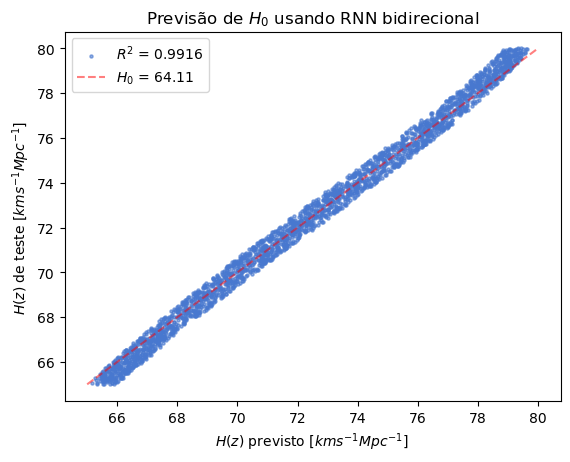

In [17]:
plt.style.use('seaborn-v0_8-muted')

# linha = np.linspace(.3, .35, 2500)
linha = np.linspace(65, 80)

plt.scatter(y_pred, y_test, s=5, alpha=.6, label=(r'$R^2$ '+ f'= {r2:.4f}'))
plt.plot(linha, linha, alpha=.5, c='red', ls='--', label=(r'$H_0$ '+ f'= {final_real[0][0]:.2f}'))

plt.legend()

plt.title('Previsão de $H_0$ usando RNN bidirecional')

plt.xlabel(r'$H (z)$ previsto [$km s^{-1} Mpc^{-1}$] ')
plt.ylabel(r'$H (z)$ de teste [$km s^{-1} Mpc^{-1}$] ')


# plt.savefig("../imagens/metrics_h0_rnn")
plt.show()

In [16]:
# model.save('../models/rnn_bi')